# Reinforcement Learning basics

*Louis Martinez*

[Link to the book](./Articles/rl-book.pdf)

This notebook is the beginning of a deep dive into Reinforcement Learning theory.  
For now it mainly focuses on function approximation and the various approaches mentioned in the Sutton and Barto's book.  
The next parts of this notebook will be dedicated to the implemation of several algorithms from the book, with a special focus on the distinction between on-policy and off-policy learning and its implications

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import random

np.random.seed(0)
random.seed(0)

---
## Defning the environment for the whole notebook

All the following theorical elements developed in this notebook will be tested on a Random Walk environment.  
One choose this experiment firstly because it is widely used by Sutton and Barto in their book as the way to illustrate core concepts. Then it is an easy to manipulate, one-dimensional problem.  
Hence graphical results can intuitively be interpreted so theorical concepts get easier to understand.

In [2]:
class RandomWalkEnv:

    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max
        self.x_start = 4 * (self.x_max - self.x_min) / 5
        self.current_state = self.x_start

    def step(self, action):
        new_state = np.clip(self.current_state + action, self.x_min, self.x_max)

        # Avoid out of bound
        # if new_state < self.x_min:
        #     new_state = self.x_min
        # elif new_state > self.x_max:
        #     new_state = self.x_max

        # Compute reward
        reward = 0
        if new_state == self.x_min:
            reward = -1
        elif new_state == self.x_max:
            reward = 1

        self.current_state = new_state

        return reward, new_state


    def is_terminal_state(self):
        return not(self.x_min < self.current_state < self.x_max)


    def random_action_policy(self):
        # return np.random.uniform(-(self.x_max-self.x_min)/10, (self.x_max-self.x_min)/10)
        return np.random.choice([-1, 1])


    def reset(self):
        self.current_state = self.x_start

    
    def random_x_start(self):
        # return np.random.uniform(low=self.x_min, high=self.x_max)
        return np.random.randint(low=self.x_min, high=self.x_max-1)

    
    def info(self):
        print(f'Walk interval : [{self.x_min:.2f}, {self.x_max:.2f}]')
        print(f'Starting state : {self.x_start:.2f}')


env = RandomWalkEnv(0., 5.)
env.info()

Walk interval : [0.00, 5.00]
Starting state : 4.00


## Funtion Approximation

This section will be dedicated to function approximation.  
Function approcimation is one of the core concepts of Reinforcement Learning. As the quality of an action (given a state) chosen by an agent is quantified by either the V-funtion, or the Q-function (difference not developed here as it is widely covered by the book), one must find a way to approximate the latter.  
Here we'll be experimenting different fucntion approximation methods (except deep-learning)

### Tile Coding (state aggregation)

In [3]:
n_tiles = 10
tile_size = (env.x_max - env.x_min) / n_tiles

alpha = 0.2/n_tiles
gamma = 0.95 # Discount factor

def value_func(s, w):
    return np.dot(s, w)

In [4]:
def encode_tile(x):

    assert env.x_min <= x <= env.x_max


    feature_vector = np.zeros(n_tiles)

    if x == env.x_max:
        feature_vector[-1] = 1
    else:
        tile_index = int((x - env.x_min) / tile_size)
        feature_vector[tile_index] = 1

    return feature_vector

In [5]:
env.reset()

n_episodes = 30_000

V = value_func # To match notations of the book

def greedy(s, eps, weights, encode_func):
    if np.random.uniform() >= eps:
        return env.random_action_policy()
    else:
        possible_actions = np.linspace(-(env.x_max-env.x_min)/10, (env.x_max-env.x_min)/10, 5)
        v_values = np.zeros(possible_actions.shape[0])

        for i, action in enumerate(possible_actions):
            next_state = encode_func(np.clip(s + action, env.x_min, env.x_max))
            v_values[i] = V(next_state,weights)

        action = np.argmax(v_values)
        return action





def find_V_func(n_episodes, encode_func, n_features):
    weights = np.zeros(n_features) # Theta

    for ep in tqdm(range(n_episodes)):
        # s = env.x_start # Initial state
        s = env.random_x_start() # Initial state

        while env.x_min < s < env.x_max: # While s is not terminal

            # Action given by pi for s
            a = env.random_action_policy()
            # a = greedy(s, 0.9, weights, encode_func)

            # Observe reward r and next_state s'
            reward, new_s = env.step(a)

            # s_encoded = encode_tile(s)
            # new_s_encoded = encode_tile(new_s)
            s_encoded = encode_func(s)
            new_s_encoded = encode_func(new_s)

            v_s = V(s_encoded, weights)
            V_new_s = V(new_s_encoded, weights)

            old_weights = weights

            weights = weights + alpha*(reward + gamma * V_new_s - v_s) * s_encoded

            s = new_s

    return weights

weights = find_V_func(n_episodes, encode_tile, n_tiles)

  5%|▌         | 1610/30000 [00:00<00:05, 5183.85it/s]

100%|██████████| 30000/30000 [00:04<00:00, 6355.33it/s]


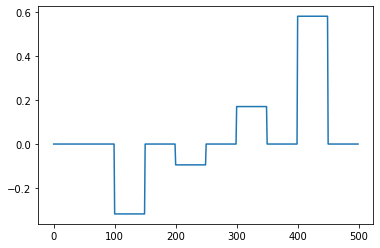

In [6]:
# test_data = np.sort(np.random.uniform(env.x_min, env.x_max, 500))
test_data = np.linspace(env.x_min, env.x_max, 500)
res = []

for x in test_data:
    encoded = encode_tile(x)
    res.append(V(encoded, weights))

plt.plot(res)

### Function approximation with multiple tile coding (coarse-to-fine coding)

In [7]:
# n_tiles = 5
# n_tilings = 4

# def multi_tile_encode(x, n_tiles, n_tilings, offset_ratio=0.2):

#     assert env.x_min <= x <= env.x_max

#     x_start = env.x_start

#     encoded = np.zeros(n_tilings * n_tiles)

#     tile_size = (env.x_max - env.x_min) / n_tiles

#     for i in range(n_tilings):
#         tile_index = 

    
    

SyntaxError: invalid syntax (3651042575.py, line 15)

### Function approximation with RBF

In [ ]:
n_features = 10
param = 3.

def RBF_encode(x):
    vals = np.linspace(env.x_min, env.x_max, n_features)
    norm = np.abs(vals - x)

    encoded = np.exp(-(param*norm)**2)

    return encoded

In [ ]:
env.reset()
n_episodes = 30_000

weights_rbf = find_V_func(n_episodes, RBF_encode, n_features)

100%|██████████| 30000/30000 [00:42<00:00, 712.52it/s]


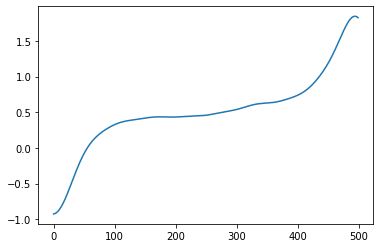

In [ ]:
test_data = np.linspace(env.x_min, env.x_max, 500)
res = []

for x in test_data:
    encoded = RBF_encode(x)
    res.append(V(encoded, weights_rbf))

plt.plot(res)